In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip install transformers

## Prerequisites

In [ ]:
# Importing the libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyoff
import plotly.graph_objs as go
from PIL import Image
from collections import Counter

import nltk
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
nltk.download(['stopwords', 'wordnet'])
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, TweetTokenizer, word_tokenize
from bs4 import BeautifulSoup
import string, unicodedata


from string import punctuation
from tqdm import tqdm
import re
import gensim

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OneHotEncoder
from sklearn.svm import LinearSVC


from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Bidirectional, Conv2D, Dense, Dropout
from keras.layers import Embedding, Input, LSTM, SpatialDropout1D
from keras.models import Model, Sequential
from keras.preprocessing import text, sequence

import tensorflow as tf
from tokenizers import BertWordPieceTokenizer
import torch
import transformers

np.random.seed(9613027)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Natural Language Processing/Corona_NLP_train.csv', encoding='latin-1')
#test = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv')

df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


### 1. Basic EDA and Data Cleaning

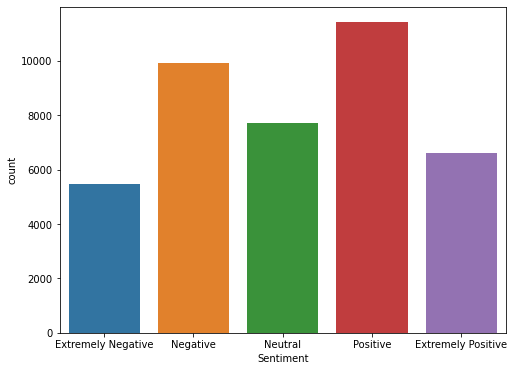

In [ ]:
plt.figure(figsize=(8, 6)) 
sns.countplot(df['Sentiment'], order=['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive'])
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [ ]:
df['Location'].isna().sum()

8590

In [ ]:
location = df['Location'].value_counts().nlargest(n=15)

fig = px.bar(y=location.values,
       x=location.index,
       orientation='v',
       color=location.index,
       text=location.values,
       color_discrete_sequence= px.colors.qualitative.Bold)

fig.update_traces(texttemplate='%{text:.2s}', 
                  textposition='outside', 
                  marker_line_color='rgb(8,48,107)', 
                  marker_line_width=1.5, 
                  opacity=0.7)

fig.update_layout(width=1000, 
                  showlegend=False, 
                  xaxis_title='Location',
                  yaxis_title='Count',
                  title='Top 15 Locations with tweet count')
fig.show()

In [ ]:
# Get all hashtags

def extract_hash_tags(string):
    hashes = re.findall(r'#(\w+)', string)
    return ' '.join(hashes)
df['hashtags'] = df['OriginalTweet'].apply(lambda x: extract_hash_tags(x))

In [ ]:
allHashTags = list(df[(df['hashtags'] != None) & (df['hashtags'] != "")]['hashtags'])
allHashTags = [tag.lower() for tag in allHashTags]
hash_df = dict(Counter(allHashTags))
top_hash_df = pd.DataFrame(list(hash_df.items()),columns = ['Word', 'Count']).reset_index(drop=True).sort_values('Count',ascending=False)[:20]
top_hash_df.head()

,Word,Count
7,coronavirus,3354
2,covid_19,723
17,covid2019,420
8,coronavirus covid19,349
134,covid19 coronavirus,257


In [ ]:
fig = px.bar(x=top_hash_df['Word'],y=top_hash_df['Count'],
       orientation='v',
       color=top_hash_df['Word'],
       text=top_hash_df['Count'],
       color_discrete_sequence= px.colors.qualitative.Bold)

fig.update_traces(texttemplate='%{text:.2s}', 
                  textposition='outside', 
                  marker_line_color='rgb(8,48,107)', 
                  marker_line_width=1.5, 
                  opacity=0.7)

fig.update_layout(width=1000, 
                  showlegend=False, 
                  xaxis_title='Word',
                  yaxis_title='Count',
                  title='Top Hashtags in COVID-19 Tweets')
fig.show()

Get all mentions

In [ ]:
def get_mentions(s):
    mentions = re.findall('(?<![@\w])@(\w{1,25})', s)
    return ' '.join(mentions)
df['mentions'] = df['OriginalTweet'].apply(lambda x: get_mentions(x))

In [ ]:
df['OriginalTweet'][0]

'@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8'

In [ ]:
df['mentions'][0]

'MeNyrbie Phil_Gahan Chrisitv'

In [ ]:
allMentions = list(df[(df['mentions'] != None) & (df['mentions'] != '')]['mentions'])
allMentions = [tag.lower() for tag in allMentions]
mentions_df = dict(Counter(allMentions))
top_mentions_df = pd.DataFrame(list(mentions_df.items()), columns=['Word', 'Count']).reset_index(drop=True).sort_values('Count', ascending=False)[:20]
top_mentions_df.head()

,Word,Count
32,realdonaldtrump,129
49,youtube,74
408,tesco,66
62,amazon,63
37,borisjohnson,62


In [ ]:
fig = px.bar(x=top_mentions_df['Word'],y=top_mentions_df['Count'],
       orientation='v',
       color=top_mentions_df['Word'],
       text=top_mentions_df['Count'],
       color_discrete_sequence= px.colors.qualitative.Bold)

fig.update_traces(texttemplate='%{text:.2s}', 
                  textposition='outside', 
                  marker_line_color='rgb(8,48,107)', 
                  marker_line_width=1.5, 
                  opacity=0.7)

fig.update_layout(width=1000, 
                  showlegend=False, 
                  xaxis_title="Word",
                  yaxis_title="Count",
                  title="Top #hashtags in Covid19 Tweets")
fig.show()

## Data Cleaning

In [ ]:
stop = set(stopwords.words('english'))

def cleaner(phrase):
    phrase = re.sub(r"won't", 'will not', phrase)
    phrase = re.sub(r"can't", 'can not', phrase)
  
    # general
    phrase = re.sub(r"n\'t", ' not', phrase)
    phrase = re.sub(r"\'re'", ' are', phrase)
    phrase = re.sub(r"\'s", ' is', phrase)
    phrase = re.sub(r"\'ll", ' will', phrase)
    phrase = re.sub(r"\'d", ' would', phrase)
    phrase = re.sub(r"\'t", ' not', phrase)
    phrase = re.sub(r"\'ve", ' have', phrase)
    phrase = re.sub(r"\'m", ' am', phrase)
    
    return phrase

cleaned_title = []

for sentance in tqdm(df['OriginalTweet'].values):
    sentance = str(sentance)
    sentance = re.sub(r'http\S+', '', sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = cleaner(sentance)
    sentance = re.sub(r'[?|!|\'|"|#|+]', r'', sentance)
    sentance = re.sub('<.*?>','',sentance)
    sentance = re.sub(r'@\w+','',sentance)
    sentance = re.sub(r'#\w+','',sentance)
    sentance = re.sub(r'[0-9]+','',sentance)
    sentance = re.sub(r'[0-9]+','',sentance)
    sentance = re.sub('\S*\d\S*', '', sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stop)
    cleaned_title.append(sentance.strip())
    
df['text'] = cleaned_title
df.head()

100%|██████████| 41157/41157 [00:12<00:00, 3219.86it/s]


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,hashtags,mentions,text
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,,MeNyrbie Phil_Gahan Chrisitv,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,,,advice talk neighbours family exchange phone n...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,,,coronavirus australia woolworths give elderly ...
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,COVID19france COVID_19 COVID19 coronavirus con...,,food stock one empty please panic enough food ...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,COVID19 coronavirus CoronavirusFrance restezch...,,ready go supermarket covid outbreak paranoid f...


## WordClouds

### Positive
Words that convey a **Positive** sentiment

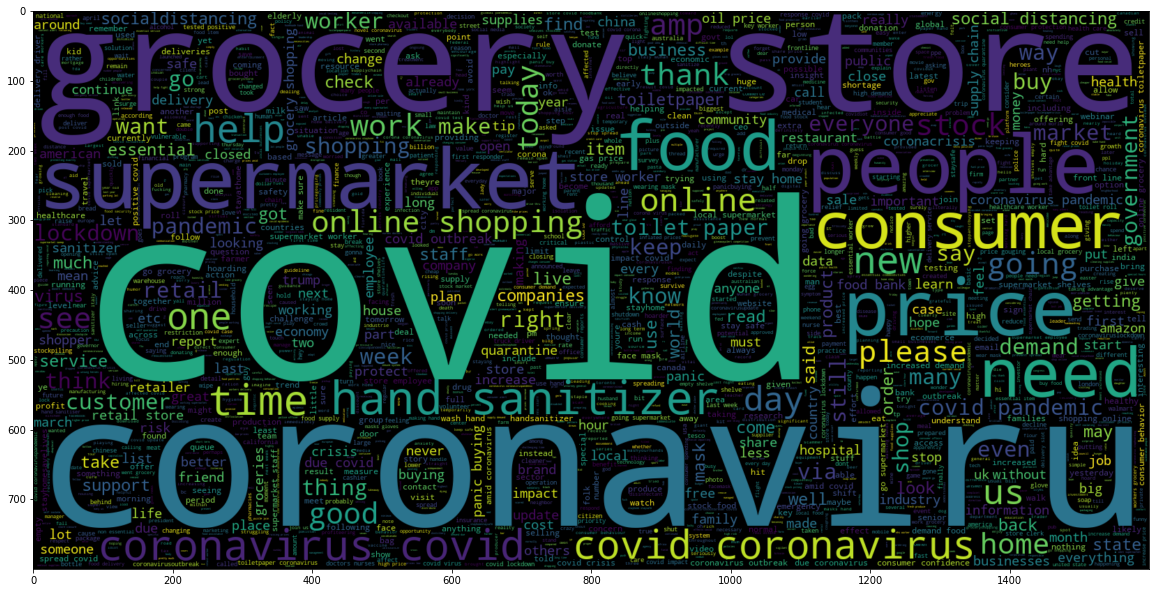

In [ ]:
plt.figure(figsize=(20, 20)) 
wc = WordCloud(max_words=2000, width=1600, height=800).generate(' '.join(df[df.Sentiment == 'Positive'].text))
plt.imshow(wc, interpolation='bilinear')
plt.show()

### Neutral
Words that convey a **Neutral** sentiment

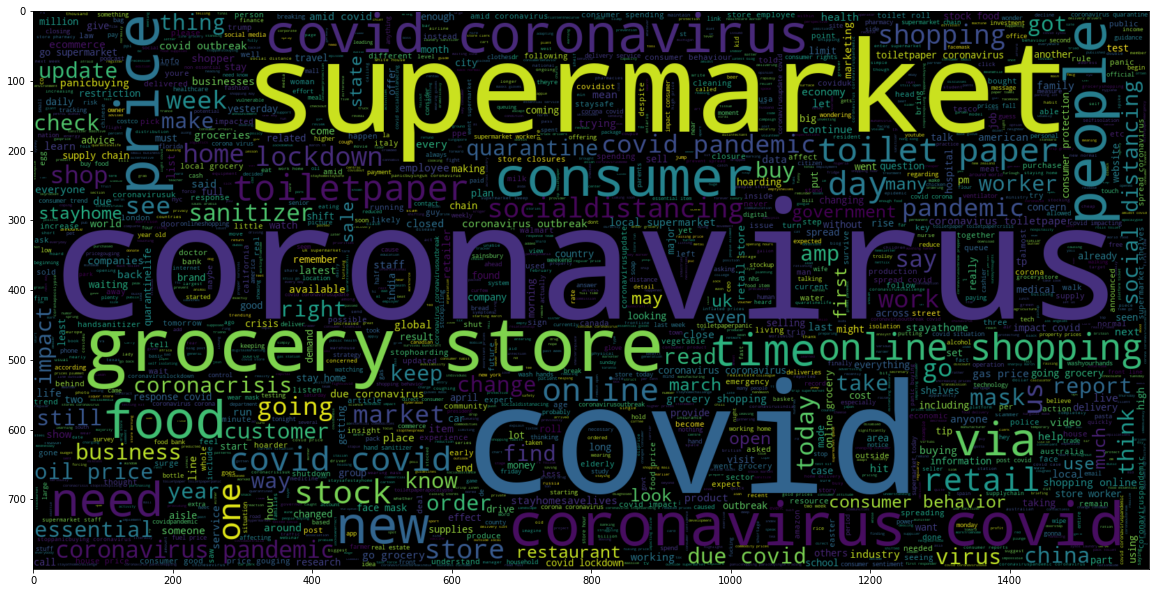

In [ ]:
plt.figure(figsize=(20, 20)) 
wc = WordCloud(max_words=2000, width=1600, height=800).generate(' '.join(df[df.Sentiment == 'Neutral'].text))
plt.imshow(wc, interpolation='bilinear')
plt.show()

### Negative
Words that convey a **Negative** sentiment

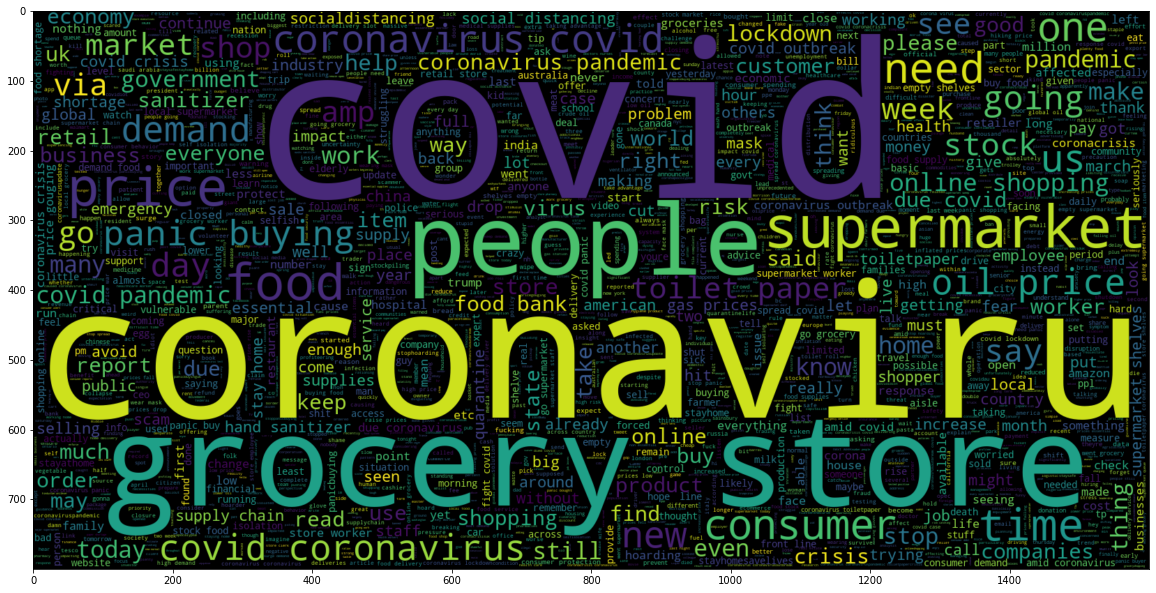

In [ ]:
plt.figure(figsize=(20, 20)) 
wc = WordCloud(max_words=2000, width=1600, height=800).generate(' '.join(df[df.Sentiment == 'Negative'].text))
plt.imshow(wc, interpolation='bilinear')
plt.show()

## $n$-gram Analysis
Continuing with some $n$-gram analysis

In [ ]:
def basic_clean(text):
  """
  A simple function to clean up the data. All the words that
  are not designated as a stop word is then lemmatized after
  encoding and basic regex parsing are performed.
  """
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english')
  text = (unicodedata.normalize('NFKD', text)
    .encode('ascii', 'ignore')
    .decode('utf-8', 'ignore')
    .lower())
  words = re.sub(r'[^\w\s]', '', text).split()
  return [wnl.lemmatize(word) for word in words if word not in stopwords]

### *Unigrams* for Tweets

In [ ]:
HQ_words = basic_clean(''.join(str(df['text'].tolist())))
unigram_HQ = (pd.Series(nltk.ngrams(HQ_words, 1)).value_counts())[:20]
unigram_HQ = pd.DataFrame(unigram_HQ)
unigram_HQ['idx'] = unigram_HQ.index
unigram_HQ['idx'] = unigram_HQ.apply(lambda x: '(' + x['idx'][0] + ')', axis=1)

In [ ]:
plot_data = [
    go.Bar(
        x=unigram_HQ['idx'],
        y=unigram_HQ[0],
        marker = dict(
            color = 'Blue'
        )
    )
]
plot_layout = go.Layout(
        title='Top 20 Unigrams from COVID-19 Tweets',
        yaxis_title='Count',
        xaxis_title='Unigram',
        plot_bgcolor='rgba(0,0,0,0)'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

### *Bigrams* for Tweets

In [ ]:
HQ_words = basic_clean(''.join(str(df[df['Sentiment'] == 'Negative']['text'].tolist())))
bigram_HQ = (pd.Series(nltk.ngrams(HQ_words, 2)).value_counts())[:20]
bigram_HQ = pd.DataFrame(bigram_HQ)
bigram_HQ['idx'] = bigram_HQ.index
bigram_HQ['idx'] = bigram_HQ.apply(lambda x: '(' + x['idx'][0] +
                                   ', ' + x['idx'][1] + ')', axis=1)

In [ ]:
plot_data = [
    go.Bar(
        x=bigram_HQ['idx'],
        y=bigram_HQ[0],
        marker = dict(
            color = 'Red'
        )
    )
]
plot_layout = go.Layout(
        title='Top 20 Bigrams from COVID-19 Tweets',
        yaxis_title='Count',
        xaxis_title='Bigram',
        plot_bgcolor='rgba(0,0,0,0)'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

### *Trigrams* for Tweets

In [ ]:
HQ_words = basic_clean(''.join(str(df['text'].tolist())))
trigram_HQ = (pd.Series(nltk.ngrams(HQ_words, 3)).value_counts())[:20]
trigram_HQ = pd.DataFrame(trigram_HQ)
trigram_HQ['idx'] = trigram_HQ.index
trigram_HQ['idx'] = trigram_HQ.apply(lambda x: '(' + x['idx'][0] + ', ' + x['idx'][1]
                                     + ', ' + x['idx'][2] + ')', axis=1)

In [ ]:
plot_data = [
    go.Bar(
        x=trigram_HQ['idx'],
        y=trigram_HQ[0],
        marker = dict(
            color = 'Green'
        )
    )
]
plot_layout = go.Layout(
        title='Top 20 Trigrams from COVID-19 Tweets',
        yaxis_title='Count',
        xaxis_title='Trigram',
        plot_bgcolor='rgba(0,0,0,0)'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

As observed, people tend to worry about where they get their groceries.

## 2. Model Building

In [ ]:
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Natural Language Processing/Corona_NLP_test.csv', encoding='latin-1')
test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [ ]:
cleaned_title = []

for sentance in tqdm(test['OriginalTweet'].values):
    sentance = str(sentance)
    sentance = re.sub(r'http\S+', '', sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = cleaner(sentance)
    sentance = re.sub(r'[?|!|\'|"|#|+]', r'', sentance)
    sentance = re.sub('<.*?>','',sentance)
    sentance = re.sub(r'@\w+','',sentance)
    sentance = re.sub(r'#\w+','',sentance)
    sentance = re.sub(r'[0-9]+','',sentance)
    sentance = re.sub(r'[0-9]+','',sentance)
    sentance = re.sub('\S*\d\S*', '', sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stop)
    cleaned_title.append(sentance.strip())
    
test['text'] = cleaned_title
test.head()

100%|██████████| 3798/3798 [00:01<00:00, 3138.05it/s]


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,text
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,trending new yorkers encounter empty supermark...
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive,could find hand sanitizer fred meyer turned am...
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive,find protect loved ones coronavirus
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative,panic buying hits newyork city anxious shopper...
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,toiletpaper dunnypaper coronavirus coronavirus...


In [ ]:
df['text'].replace('', np.nan, inplace=True)
df.dropna(subset=['text'], inplace=True)

df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,hashtags,mentions,text
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,,,advice talk neighbours family exchange phone n...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,,,coronavirus australia woolworths give elderly ...
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,COVID19france COVID_19 COVID19 coronavirus con...,,food stock one empty please panic enough food ...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,COVID19 coronavirus CoronavirusFrance restezch...,,ready go supermarket covid outbreak paranoid f...
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,Positive,,Tim_Dodson,news region first confirmed covid case came su...


### Location Filters

In [ ]:
df['Location'].fillna('None', inplace = True)

Below are some of the common locations found in the tweets that will help us properly map more tweets to a particular country.

In [ ]:
# Some frequent US locations
us_filters = ('New York', 'New York, NY', 'NYC', 'NY', 'Washington, DC', 'Los Angeles, CA',
             'Seattle, Washington', 'Chicago', 'Chicago, IL', 'California, USA', 'Atlanta, GA',
             'San Francisco, CA', 'Boston, MA', 'New York, USA', 'Texas, USA', 'Austin, TX',
             'Houston, TX', 'New York City', 'Philadelphia, PA', 'Florida, USA', 'Seattle, WA',
             'Washington, D.C.', 'San Diego, CA', 'Las Vegas, NV', 'Dallas, TX', 'Denver, CO',
             'New Jersey, USA', 'Brooklyn, NY', 'California', 'Michigan, USA', 'Minneapolis, MN',
             'Virginia, USA', 'Miami, FL', 'Texas', 'Los Angeles', 'United States', 'San Francisco',
             'Indianapolis, IN', 'Pennsylvania, USA', 'Phoenix, AZ', 'New Jersey', 'Baltimore, MD',
             'CA', 'FL', 'DC', 'TX', 'IL', 'MA', 'PA', 'GA', 'NC', 'NJ', 'WA', 'VA', 'PAK', 'MI', 'OH',
             'CO', 'AZ', 'D.C.', 'WI', 'MD', 'MO', 'TN', 'Florida', 'IN', 'NV', 'MN', 'OR','LA', 'Michigan',
             'CT', 'SC', 'OK', 'Illinois', 'Ohio', 'UT', 'KY', 'Arizona', 'Colorado')

# Various nations' frequent locations
uk_filters = ('England', 'London', 'london', 'United Kingdom', 'united kingdom',
              'England, United Kingdom', 'London, UK', 'London, England',
              'Manchester, England', 'Scotland, UK', 'Scotland', 'Scotland, United Kingdom',
              'Birmingham, England', 'UK', 'Wales')
india_filters = ('New Delhi, India', 'Mumbai', 'Mumbai, India', 'New Delhi', 'India', 
                 'Bengaluru, India')
australia_filters = ('Sydney, Australia', 'New South Wales', 'Melbourne, Australia', 'Sydney',
                     'Sydney, New South Wales', 'Melbourne, Victoria', 'Melbourne', 'Australia')
canada_filters = ('Toronto, Ontario', 'Toronto', 'Ontario, Canada', 'Toronto, Canada', 'Canada',
                  'Vancouver, British Columbia', 'Ontario', 'Victoria', 'British Columbia', 'Alberta',)
south_africa_filters = ('Johannesburg, South Africa', 'Cape Town, South Africa', 'South Africa')
nigeria_filters = ('Lagos, Nigeria')
kenya_filters = ('Nairobi, Kenya')
france_filters = ('Paris, France')
ireland_filters = ('Ireland')
new_zealand_filters = ('New Zealand')
pakistan_filters = ('Pakistan')
malaysia_filters = ('Malaysia')
uganda_filters = ('Kampala, Uganda', 'Uganda')
singapore_filters = ('Singapore')
germany_filters = ('Germany', 'Deutschland')
switz_filters = ('Switzerland')
uae_filters = ('United Arab Emirates', 'Dubai')
spain_filters = ('Spain')
belg_filters = ('Belgium')
phil_filters = ('Philippines')
hk_filters = ('Hong Kong')
ghana_filters = ('Ghana')
# These all have large counts. Need to be removed from rest of data
other_filters = ('None', 'Worldwide', 'Global', 'Earth', '??')

In [ ]:
df['country'] = df['Location'].apply(lambda x: x.split(",")[-1].strip() if ("," in x) else x)

Changing strings found with filters into 3 digit codes

In [ ]:
df['country'] = df['country'].apply(lambda x: 'USA' if x in us_filters else x)
df['country'] = df['country'].apply(lambda x: 'GBR' if x in uk_filters else x)
df['country'] = df['country'].apply(lambda x: 'IND' if x in india_filters else x)
df['country'] = df['country'].apply(lambda x: 'AUS' if x in australia_filters else x)
df['country'] = df['country'].apply(lambda x: 'CAN' if x in canada_filters else x)
df['country'] = df['country'].apply(lambda x: 'ZAF' if x in south_africa_filters else x)
df['country'] = df['country'].apply(lambda x: 'KEN' if x in kenya_filters else x)
df['country'] = df['country'].apply(lambda x: 'NGA' if x in nigeria_filters else x)
df['country'] = df['country'].apply(lambda x: 'SGP' if x in singapore_filters else x)
df['country'] = df['country'].apply(lambda x: 'FRA' if x in france_filters else x)
df['country'] = df['country'].apply(lambda x: 'NZL' if x in new_zealand_filters else x)
df['country'] = df['country'].apply(lambda x: 'PAK' if x in pakistan_filters else x)
df['country'] = df['country'].apply(lambda x: 'MYS' if x in malaysia_filters else x)
df['country'] = df['country'].apply(lambda x: 'IRL' if x in ireland_filters else x)
df['country'] = df['country'].apply(lambda x: 'UGA' if x in uganda_filters else x)
df['country'] = df['country'].apply(lambda x: 'DEU' if x in germany_filters else x)
df['country'] = df['country'].apply(lambda x: 'CHE' if x in switz_filters else x)
df['country'] = df['country'].apply(lambda x: 'ARE' if x in uae_filters else x)
df['country'] = df['country'].apply(lambda x: 'ESP' if x in spain_filters else x)
df['country'] = df['country'].apply(lambda x: 'BEL' if x in belg_filters else x)
df['country'] = df['country'].apply(lambda x: 'PHL' if x in phil_filters else x)
df['country'] = df['country'].apply(lambda x: 'GHA' if x in ghana_filters else x)
df['country'] = df['country'].apply(lambda x: 'HKG' if x in hk_filters else x)
df['country'] = df['country'].apply(lambda x: 'None' if x in other_filters else x)

In [ ]:
df['Location'].value_counts()

None                            8579
London                           539
United States                    526
London, England                  520
New York, NY                     395
                                ... 
Brooklyn, N.Y.                     1
a big gay world of my own          1
Beirut                             1
iPhone: 37.200417,-77.334244       1
USA/Singapore                      1
Name: Location, Length: 12212, dtype: int64

#### Vizualization

In [ ]:
# 0:30 because that's where the labeled countries end
places_df = pd.DataFrame(df['country'].value_counts()[0:30])
places_df.reset_index(inplace = True)
places_df.rename(columns = {'index':'Country', 'country':'Tweets'}, inplace = True)
# Remove 'None' location
places_df = places_df[places_df['Country'] != 'None']

In [ ]:
data = dict(type='choropleth',
            colorscale = 'inferno',
            locations = places_df['Country'],
            z = places_df['Tweets'],
            #locationmode = 'USA-states',
            text = places_df['Tweets'],
            marker = dict(line = dict(color = 'rgb(255,255,255)',width = 2)),
            colorbar = {'title':"Number of Tweets"}
            ) 

layout = dict(title = 'Number of Tweets By Country',
              geo = dict(#scope='usa',
                         showlakes = False,
                         lakecolor = 'rgb(85,173,240)',
                         projection_type='equirectangular')
             )

choromap = go.Figure(data = [data],layout = layout)

In [ ]:
pyoff.iplot(choromap)

The vast majority of tweets come from English speaking countries, which makes sense, since these tweets are all in English. Largest contributor is the USA followed by the UK and Canada.

'grocery store', 'price', 'supermarket', and 'online shopping' being frequent in positive, neutral, and negative tweets is interesting. Some stand-out negative terms are 'panic buying' and 'toilet paper'. For positive, 'hand sanitizer' catches my attention.

In [ ]:
df.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment', 'hashtags', 'mentions', 'text', 'country'],
      dtype='object')

In [ ]:
train = df.copy()
train.drop(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
            'hashtags', 'mentions'], axis=1, inplace=True)

In [ ]:
train.head()

,Sentiment,text,country
1,Positive,advice talk neighbours family exchange phone n...,GBR
2,Positive,coronavirus australia woolworths give elderly ...,Vagabonds
3,Positive,food stock one empty please panic enough food ...,None
4,Extremely Negative,ready go supermarket covid outbreak paranoid f...,None
5,Positive,news region first confirmed covid case came su...,-82.363649


In [ ]:
X = train.text

In [ ]:
def target(label):
    if label == 'Neutral': 
        return 0
    if label == 'Positive' or label == 'Extremely Positive':
        return 1
    else:
        return -1

In [ ]:
train['label'] = train['Sentiment'].apply(target)
train.head()

,Sentiment,text,country,label
1,Positive,advice talk neighbours family exchange phone n...,GBR,1
2,Positive,coronavirus australia woolworths give elderly ...,Vagabonds,1
3,Positive,food stock one empty please panic enough food ...,None,1
4,Extremely Negative,ready go supermarket covid outbreak paranoid f...,None,-1
5,Positive,news region first confirmed covid case came su...,-82.363649,1


### Split into *Train* and *Test* sets

In [ ]:
X = train['text']
y = train['label']

In [ ]:
X_Train, X_test, y_Train, y_test = train_test_split(X, y, test_size=0.1,
                                                    random_state=27, stratify=y)

X_train, X_cross, y_train, y_cross = train_test_split(X_Train, y_Train,
                                                      test_size=0.1,
                                                      random_state=27,
                                                      stratify=y_Train)

We'll try four different classifiers: $SVC$, $Logistic Regression$, $Naive Bayes$, and $Random Forest$. Furthermore, we'll also be testing whether these models perform better using $TF/IDF$ or just a simple $Count$ for the vectors we feed into the model. $TF/IDF$ increases every time a word appears in a document (tweet), but is then offset for every document (tweet) that word appears. This can help pick out the more important words for classification. Additionally, we'll be using cross validation to help gauge each model's accuracy and variance across multiple splits of the data.

In [ ]:
clf = dict({'SVC': LinearSVC(max_iter = 5000),
            'Logisitc': LogisticRegression(max_iter = 5000),
            'NaiveBayes': MultinomialNB(),
            'RandomForest': RandomForestClassifier(),
           })

In [ ]:
def make_models(clf, vectorizer, X_train, y_train, cv = 5):
    
    acc_df = pd.DataFrame(index=range(cv * len(clf)))
    results = []
    for classifier in clf.keys():
        model = Pipeline([('vectorizer',vectorizer),
                   ('clf', clf[classifier])])
        model.fit(X_train, y_train)
        scores = cross_val_score(model, X_train , y_train, cv = cv)
        model_name = classifier
        for fold, score in enumerate(scores):
            results.append((model_name, fold, score))
    
    acc_df = pd.DataFrame(results, columns=['model_name', 'fold', 'accuracy'])
    
    return acc_df

$5$-fold Cross Validation

In [ ]:
cv = 5

$Logistic$ and $Random Forest$ take much longer than $SVC$ and $Naive Bayes$.

In [ ]:
tfidf_df = make_models(clf, TfidfVectorizer(), X_Train, y_Train, cv)
count_df = make_models(clf, CountVectorizer(), X_Train, y_Train, cv)
tfidf_df['vectorizer'] = 'tfidf'
count_df['vectorizer'] = 'count'
combined_df = tfidf_df.append(count_df)
combined_df['method'] = 'none'
combined_df.head(10)

,model_name,fold,accuracy,vectorizer,method
0,SVC,0,0.809781,tfidf,none
1,SVC,1,0.801675,tfidf,none
2,SVC,2,0.802216,tfidf,none
3,SVC,3,0.809646,tfidf,none
4,SVC,4,0.804377,tfidf,none
5,Logisitc,0,0.791678,tfidf,none
6,Logisitc,1,0.785328,tfidf,none
7,Logisitc,2,0.790327,tfidf,none
8,Logisitc,3,0.796271,tfidf,none
9,Logisitc,4,0.787220,tfidf,none


In [ ]:
def token_stem(tweet):
    tk = TweetTokenizer()
    stemmer = PorterStemmer()
    tweet = tk.tokenize(tweet)
    tweet = [stemmer.stem(word) for word in tweet]
    tweet =  tweet = " ".join([word for word in tweet])
    return tweet

In [ ]:
def token_lemma(tweet):
    tk = TweetTokenizer()
    lemma = WordNetLemmatizer()
    tweet = tk.tokenize(tweet)
    tweet = [lemma.lemmatize(word) for word in tweet]
    tweet = " ".join([word for word in tweet])
    return tweet

In [ ]:
df['stemTweet'] = train['text'].apply(lambda x: token_stem(x))
df['lemmaTweet'] = train['text'].apply(lambda x: token_lemma(x))
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,hashtags,mentions,text,country,stemTweet,lemmaTweet
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,,,advice talk neighbours family exchange phone n...,GBR,advic talk neighbour famili exchang phone numb...,advice talk neighbour family exchange phone nu...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,,,coronavirus australia woolworths give elderly ...,Vagabonds,coronaviru australia woolworth give elderli di...,coronavirus australia woolworth give elderly d...
3,3802,48754,None,16-03-2020,My food stock is not the only one which is emp...,Positive,COVID19france COVID_19 COVID19 coronavirus con...,,food stock one empty please panic enough food ...,None,food stock one empti pleas panic enough food e...,food stock one empty please panic enough food ...
4,3803,48755,None,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,COVID19 coronavirus CoronavirusFrance restezch...,,ready go supermarket covid outbreak paranoid f...,None,readi go supermarket covid outbreak paranoid f...,ready go supermarket covid outbreak paranoid f...
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,Positive,,Tim_Dodson,news region first confirmed covid case came su...,-82.363649,news region first confirm covid case came sull...,news region first confirmed covid case came su...


In [ ]:
# Set X and y.
X = df['stemTweet']
y = train['label']

# Split data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

stem_tfidf_df = make_models(clf, TfidfVectorizer(), X_train, y_train, cv)
stem_count_df = make_models(clf, CountVectorizer(), X_train, y_train, cv)

stem_tfidf_df['method'] = 'stem'
stem_tfidf_df['vectorizer'] = 'tfidf'
stem_count_df['method'] = 'stem'
stem_count_df['vectorizer'] = 'count'
stem_df = stem_tfidf_df.append(stem_count_df)

In [ ]:
# Set X and y.
X = df['lemmaTweet']
y = train['label']

# Split data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lemma_tfidf_df = make_models(clf, TfidfVectorizer(), X_train, y_train, cv)
lemma_count_df = make_models(clf, CountVectorizer(), X_train, y_train, cv)

lemma_tfidf_df['vectorizer'] = 'tfidf'
lemma_tfidf_df['method'] = 'lemma'
lemma_count_df['vectorizer'] = 'count'
lemma_count_df['method'] = 'lemma'
lemma_df = lemma_tfidf_df.append(lemma_count_df)

In [ ]:
all_df = lemma_df.append(stem_df)
all_df = all_df.append(combined_df)

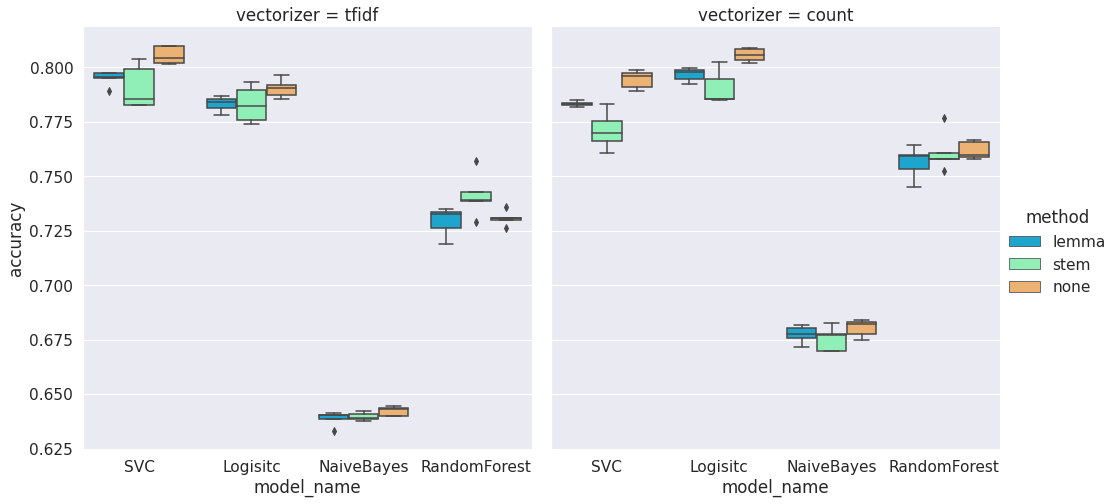

In [ ]:
sns.set(font_scale=1.4)
sns.catplot(x='model_name', y='accuracy', hue='method', height=7,
            data=all_df, kind='box', col='vectorizer', palette='rainbow')
plt.show()

$Naive Bayes$ and $Random Forest$ do much worse than $Logistic$ and $SVC$, and make the boxplots fairly hard to look at. Let's drop them for better visuals.

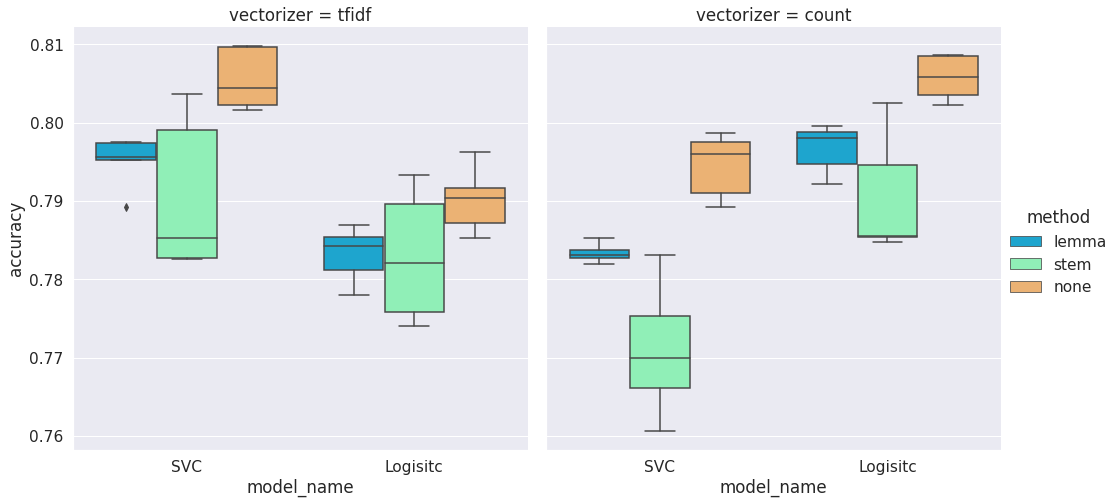

In [ ]:
no_nb = all_df[all_df['model_name'] != 'NaiveBayes']
no_nb_rf = no_nb[no_nb['model_name'] != 'RandomForest']
sns.set(font_scale = 1.4)
sns.catplot(x='model_name', y='accuracy', hue='method', height=7,
            data=no_nb_rf, kind='box', col='vectorizer', palette='rainbow')
plt.show()

$SVC$ does better when using $TF/IDF$, and $Logistic Regression$ does better when using $count$. *Stemming* seems to do worse than *lemmatization* accuracy wise, although *lemmatization* has more outliers. The best results tend to come from using neither *lemmatization* nor *stemming* on the tweets.

$SVC$ using $TF/IDF$ and $Logistic$ with $count$ have approximately the same median, but the $SVC$ has less variance and a slightly more even distribution.

It should be noted that the differences in accuracies between the best performing models are very small, and are probably due to the random splits more than methodology. Bearing that in mind, I would select the $LinearSVC$ using $TF/IDF$ and no *lemma/stem* because it takes MUCH less time to run than the $Logistic Regression$, and based on these results, it has less variance.

In [ ]:
accuracies = all_df.groupby(['model_name', 'method', 'vectorizer']).accuracy.mean()
stdDev = all_df.groupby(['model_name', 'method', 'vectorizer']).accuracy.std()
metrics_df = pd.concat([accuracies, stdDev], axis = 1, ignore_index = True)
metrics_df.columns = ['mean_acc', 'mean_std']

In [ ]:
metrics_df.sort_values(by=['mean_acc','method'], ascending=False).head(10)

mean_acc  mean_std
model_name method vectorizer                    
Logisitc   none   count       0.805782  0.002911
SVC        none   tfidf       0.805539  0.003943
Logisitc   lemma  count       0.796644  0.003093
SVC        lemma  tfidf       0.795003  0.003414
           none   count       0.794488  0.004144
           stem   tfidf       0.790626  0.009970
Logisitc   stem   count       0.790596  0.007830
           none   tfidf       0.790165  0.004233
SVC        lemma  count       0.783330  0.001246
Logisitc   lemma  tfidf       0.783117  0.003587

### Split into *Train* and *Test* sets

In [ ]:
X = train['text']
train['label'] = train['Sentiment'].apply(target)
y = train['label']

In [ ]:
X_Train, X_test, y_Train, y_test = train_test_split(X, y, test_size=0.1,
                                                    random_state=27, stratify=y)

X_train, X_cross, y_train, y_cross = train_test_split(X_Train, y_Train,
                                                      test_size=0.1,
                                                      random_state=27,
                                                      stratify=y_Train)

### $TF/IDF$

In [ ]:
tf_idf = TfidfVectorizer(use_idf=True, ngram_range=(1, 2))

tf_idf.fit(X_train)
Train_TFIDF = tf_idf.transform(X_train)
CrossVal_TFIDF = tf_idf.transform(X_cross)
Test_TFIDF= tf_idf.transform(X_test)

## Logistic Regression

In [ ]:
c = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
Train_AUC_TFIDF = []
CrossVal_AUC_TFIDF = []
for i in c:
  logreg = LogisticRegression(C=i, penalty='l2')
  logreg.fit(Train_TFIDF, y_train)
  Train_y_pred = logreg.predict_proba(Train_TFIDF)[0:,]
  Train_AUC_TFIDF.append(roc_auc_score(y_train, Train_y_pred, multi_class='ovr'))
  CrossVal_y_pred = logreg.predict_proba(CrossVal_TFIDF)[0:,]
  CrossVal_AUC_TFIDF.append(roc_auc_score(y_cross, CrossVal_y_pred, multi_class='ovr'))

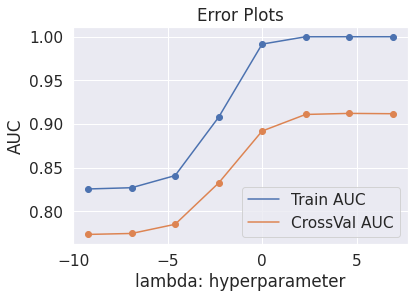

In [ ]:
C = []
for i in range(len(c)):
  C.append(np.math.log(c[i]))

plt.plot(C, Train_AUC_TFIDF, label='Train AUC')
plt.scatter(C, Train_AUC_TFIDF)
plt.plot(C, CrossVal_AUC_TFIDF, label='CrossVal AUC')
plt.scatter(C, CrossVal_AUC_TFIDF)
plt.legend()
plt.xlabel('lambda: hyperparameter')
plt.ylabel('AUC')
plt.title('Error Plots')
plt.show()

In [ ]:
optimal_inverse_lambda = c[CrossVal_AUC_TFIDF.index(max(CrossVal_AUC_TFIDF))]
print(pow(optimal_inverse_lambda, -1))

0.01


In [ ]:
Classifier = LogisticRegression(C=optimal_inverse_lambda, penalty='l2')
Classifier.fit(Train_TFIDF, y_train)

auc_train_tfidf = roc_auc_score(y_train,Classifier.predict_proba(Train_TFIDF)[0:,], multi_class='ovr')
print("AUC for Train set:\t", auc_train_tfidf)

auc_test_tfidf = roc_auc_score(y_test,Classifier.predict_proba(Test_TFIDF)[0:,], multi_class='ovr')
print("AUC for Test set:\t", auc_test_tfidf)

AUC for Train set:	 0.9999952984198565
AUC for Test set:	 0.9137323441430732


Confusion Matrix of Test Data
[[1258   95  187]
 [ 146  465  157]
 [ 196   85 1524]]
Accuracy Score on test: 0.7894480914174569


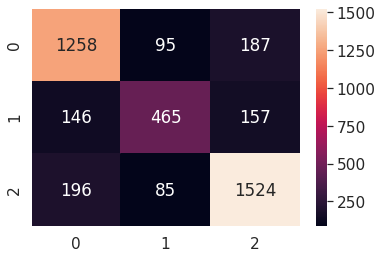

In [ ]:
y_pred = Classifier.predict(Test_TFIDF)
print('Confusion Matrix of Test Data')
Test_mat = confusion_matrix(y_test, y_pred)
print(Test_mat)

print('Accuracy Score on test:', accuracy_score(y_test, y_pred))
sns.heatmap(Test_mat, annot=True, fmt='d')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.79      0.82      0.80      1540
     Neutral       0.72      0.61      0.66       768
    Positive       0.82      0.84      0.83      1805

    accuracy                           0.79      4113
   macro avg       0.77      0.76      0.76      4113
weighted avg       0.79      0.79      0.79      4113



## 3. Neural Network

### LSTM

In [ ]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 300
EMBEDDING_DIM = 100
tokenizer = text.Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 43494 unique tokens.


In [ ]:
x = tokenizer.texts_to_sequences(X.values)
x = sequence.pad_sequences(x, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', x.shape)

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, stratify=y)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

Shape of data tensor: (41123, 300)
(28786, 300) (28786,)
(12337, 300) (12337,)


In [ ]:
Y_train = np.array(Y_train)

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(Y_train)
print(Y_train)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
Y_train = onehot_encoded
print(Y_train)

[ 1  1  1 ... -1  0  1]
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [ ]:
Y_test = np.array(Y_test)

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(Y_test)
print(Y_test)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
Y_test = onehot_encoded
print(Y_test)

[ 0  0  0 ...  1 -1 -1]
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]]


### *Model* Parameters

In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=x.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10
405/405 [==============================] - 336s 821ms/step - loss: 0.9003 - accuracy: 0.5586 - val_loss: 0.5453 - val_accuracy: 0.7881
Epoch 2/10
405/405 [==============================] - 327s 807ms/step - loss: 0.3801 - accuracy: 0.8712 - val_loss: 0.4928 - val_accuracy: 0.8260
Epoch 3/10
405/405 [==============================] - 328s 810ms/step - loss: 0.2203 - accuracy: 0.9304 - val_loss: 0.5518 - val_accuracy: 0.8152
Epoch 4/10
405/405 [==============================] - 329s 813ms/step - loss: 0.1577 - accuracy: 0.9509 - val_loss: 0.6175 - val_accuracy: 0.8131
Epoch 5/10
405/405 [==============================] - 328s 810ms/step - loss: 0.1099 - accuracy: 0.9670 - val_loss: 0.6898 - val_accuracy: 0.7968


In [ ]:
acc = model.evaluate(X_test,Y_test)
print('Test set\n\tLoss: {:0.3f}\n\tAccuracy: {:0.3f}'.format(acc[0], acc[1]))

386/386 [==============================] - 29s 74ms/step - loss: 0.7030 - accuracy: 0.8020
Test set
	Loss: 0.703
	Accuracy: 0.802
